In [1]:
!pip install librosa tensorflow matplotlib seaborn scikit-learn

import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import re
import pickle
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Constants for feature extraction
SAMPLE_RATE = 22050
DURATION = 3  # seconds
N_MFCC = 13
HOP_LENGTH = 512
N_FFT = 2048
SAMPLES = SAMPLE_RATE * DURATION

# Create directory for processed data
!mkdir -p processed_data

"""## 1. Download and Extract Dataset"""

from google.colab import files
# files.upload()  # Uncomment and run this to upload your kaggle.json

!unzip -q '/content/drive/My Drive/speech-em.zip' -d /content/dataset


Starting dataset processing...
Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Processed 1500 files
Processed 1600 files
Processed 1700 files
Processed 1800 files
Processed 1900 files
Processed 2000 files
Processed 2100 files
Processed 2200 files
Processed 2300 files
Processed 2400 files
Processed 2500 files
Processed 2600 files
Processed 2700 files
Processed 2800 files
Processed 2900 files
Processed 3000 files
Processed 3100 files
Processed 3200 files
Processed 3300 files
Processed 3400 files
Processed 3500 files
Processed 3600 files
Processed 3700 files
Processed 3800 files
Processed 3900 files
Processed 4000 files
Processed 4100 files
Processed 4200 files
Processed 4300 files
Processed 4400 files
Processed 4500 files
Processed 4600 files
Processed 47

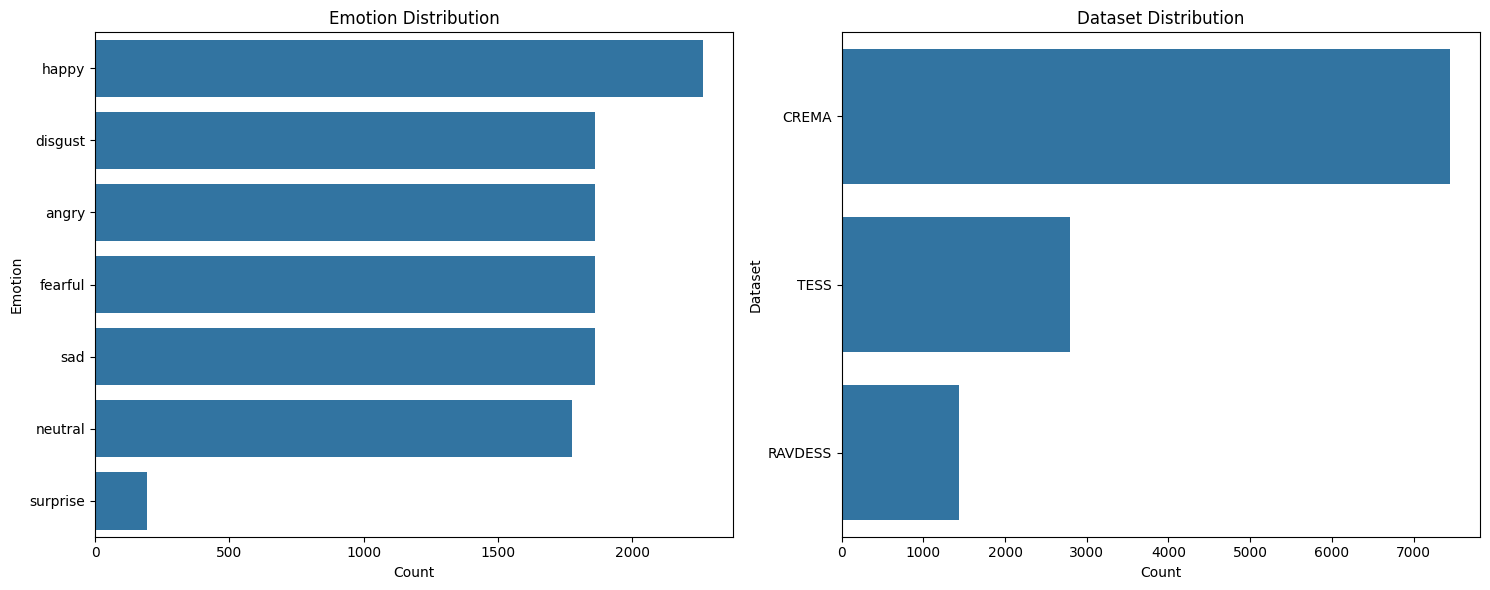

Preparing features...
Starting training...
Training data shape: (9345, 130, 13)
Testing data shape: (2337, 130, 13)
Number of emotion classes: 7
Emotion classes: ['angry' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprise']


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 130, 256)       │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 130, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 130, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,127 (1.91 MB)

 Trainable params: 499,975 (1.91 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2618 - loss: 2.1488
Epoch 1: val_accuracy improved from -inf to 0.39538, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.2620 - loss: 2.1479 - val_accuracy: 0.3954 - val_loss: 1.4807 - learning_rate: 0.0010
Epoch 2/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3868 - loss: 1.5492
Epoch 2: val_accuracy improved from 0.39538 to 0.45999, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3869 - loss: 1.5489 - val_accuracy: 0.4600 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 3/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4416 - loss: 1.4028
Epoch 3: val_accuracy improved from 0.45999 to 0.47368, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.4417 - loss: 1.4028 - val_accuracy: 0.4737 - val_loss: 1.3419 - learning_rate: 0.0010
Epoch 4/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4791 - loss: 1.3290
Epoch 4: val_accuracy improved from 0.47368 to 0.49593, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.4792 - loss: 1.3289 - val_accuracy: 0.4959 - val_loss: 1.2541 - learning_rate: 0.0010
Epoch 5/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4953 - loss: 1.2783
Epoch 5: val_accuracy improved from 0.49593 to 0.52888, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4953 - loss: 1.2783 - val_accuracy: 0.5289 - val_loss: 1.1895 - learning_rate: 0.0010
Epoch 6/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5083 - loss: 1.2471
Epoch 6: val_accuracy did not improve from 0.52888
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5084 - loss: 1.2470 - val_accuracy: 0.5229 - val_loss: 1.1849 - learning_rate: 0.0010
Epoch 7/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5390 - loss: 1.1921
Epoch 7: val_accuracy improved from 0.52888 to 0.56098, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5389 - loss: 1.1921 - val_accuracy: 0.5610 - val_loss: 1.1233 - learning_rate: 0.0010
Epoch 8/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5314 - loss: 1.1974
Epoch 8: val_accuracy did not improve from 0.56098
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5314 - loss: 1.1972 - val_accuracy: 0.5233 - val_loss: 1.1761 - learning_rate: 0.0010
Epoch 9/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5578 - loss: 1.1414
Epoch 9: val_accuracy improved from 0.56098 to 0.56397, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5578 - loss: 1.1415 - val_accuracy: 0.5640 - val_loss: 1.1258 - learning_rate: 0.0010
Epoch 10/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5552 - loss: 1.1482
Epoch 10: val_accuracy did not improve from 0.56397
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5551 - loss: 1.1483 - val_accuracy: 0.4959 - val_loss: 1.2967 - learning_rate: 0.0010
Epoch 11/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5523 - loss: 1.1554
Epoch 11: val_accuracy improved from 0.56397 to 0.56611, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5523 - loss: 1.1554 - val_accuracy: 0.5661 - val_loss: 1.1453 - learning_rate: 0.0010
Epoch 12/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5684 - loss: 1.1131
Epoch 12: val_accuracy improved from 0.56611 to 0.57467, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5683 - loss: 1.1133 - val_accuracy: 0.5747 - val_loss: 1.1229 - learning_rate: 0.0010
Epoch 13/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5706 - loss: 1.1124
Epoch 13: val_accuracy did not improve from 0.57467
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5706 - loss: 1.1124 - val_accuracy: 0.5208 - val_loss: 1.1757 - learning_rate: 0.0010
Epoch 14/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5531 - loss: 1.1230
Epoch 14: val_accuracy improved from 0.57467 to 0.58023, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5532 - loss: 1.1228 - val_accuracy: 0.5802 - val_loss: 1.0543 - learning_rate: 0.0010
Epoch 15/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5863 - loss: 1.0679
Epoch 15: val_accuracy did not improve from 0.58023
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5862 - loss: 1.0680 - val_accuracy: 0.5229 - val_loss: 1.2177 - learning_rate: 0.0010
Epoch 16/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5958 - loss: 1.0303
Epoch 16: val_accuracy improved from 0.58023 to 0.59307, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5958 - loss: 1.0303 - val_accuracy: 0.5931 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 17/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6084 - loss: 1.0338
Epoch 17: val_accuracy did not improve from 0.59307
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6084 - loss: 1.0338 - val_accuracy: 0.5828 - val_loss: 1.0567 - learning_rate: 0.0010
Epoch 18/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6129 - loss: 1.0013
Epoch 18: val_accuracy did not improve from 0.59307
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6128 - loss: 1.0017 - val_accuracy: 0.5011 - val_loss: 1.2609 - learning_rate: 0.0010
Epoch 19/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6027 - loss: 1.0393
Epoch 19: val_accuracy did not improve from 0.59307
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6027 - loss: 1.0393 - val_accuracy: 0.5785 - val_loss: 1.1039 - learning_rate: 0.0010
Epoch 20/50

293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6159 - loss: 1.0172 - val_accuracy: 0.6132 - val_loss: 1.0256 - learning_rate: 0.0010
Epoch 22/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6160 - loss: 0.9981
Epoch 22: val_accuracy did not improve from 0.61318
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6159 - loss: 0.9985 - val_accuracy: 0.5576 - val_loss: 1.1564 - learning_rate: 0.0010
Epoch 23/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5924 - loss: 1.0485
Epoch 23: val_accuracy did not improve from 0.61318
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5924 - loss: 1.0484 - val_accuracy: 0.6072 - val_loss: 1.0215 - learning_rate: 0.0010
Epoch 24/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6328 - loss: 0.9565
Epoch 24: val_accuracy improved from 0.61318 to 0.61489, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6327 - loss: 0.9566 - val_accuracy: 0.6149 - val_loss: 0.9833 - learning_rate: 0.0010
Epoch 25/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6506 - loss: 0.9353
Epoch 25: val_accuracy improved from 0.61489 to 0.63586, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.6505 - loss: 0.9355 - val_accuracy: 0.6359 - val_loss: 0.9572 - learning_rate: 0.0010
Epoch 26/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6404 - loss: 0.9442
Epoch 26: val_accuracy improved from 0.63586 to 0.66239, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6404 - loss: 0.9441 - val_accuracy: 0.6624 - val_loss: 0.9178 - learning_rate: 0.0010
Epoch 27/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6424 - loss: 0.9461
Epoch 27: val_accuracy did not improve from 0.66239
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6424 - loss: 0.9461 - val_accuracy: 0.6478 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 28/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6571 - loss: 0.9165
Epoch 28: val_accuracy did not improve from 0.66239
293/293 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6571 - loss: 0.9166 - val_accuracy: 0.6453 - val_loss: 0.9326 - learning_rate: 0.0010
Epoch 29/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6651 - loss: 0.8975
Epoch 29: val_accuracy did not improve from 0.66239
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6651 - loss: 0.8976 - val_accuracy: 0.6303 - val_loss: 0.9818 - learning_rate: 0.0010
Epoch 30/50

293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6828 - loss: 0.8494 - val_accuracy: 0.6761 - val_loss: 0.8887 - learning_rate: 0.0010
Epoch 36/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7044 - loss: 0.8299
Epoch 36: val_accuracy did not improve from 0.67608
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7043 - loss: 0.8300 - val_accuracy: 0.6573 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 37/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7035 - loss: 0.8217
Epoch 37: val_accuracy did not improve from 0.67608
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7035 - loss: 0.8218 - val_accuracy: 0.5447 - val_loss: 1.1858 - learning_rate: 0.0010
Epoch 38/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6930 - loss: 0.8360
Epoch 38: val_accuracy did not improve from 0.67608
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6930 - loss: 0.8360 - val_accuracy: 0.6645 - val_loss: 0.9123 - learning_rate: 0.0010
Epoch 39/5

293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7218 - loss: 0.7526 - val_accuracy: 0.6936 - val_loss: 0.8325 - learning_rate: 5.0000e-04
Epoch 42/50
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7408 - loss: 0.7026
Epoch 42: val_accuracy improved from 0.69362 to 0.71117, saving model to emotion_model_best.h5


293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7409 - loss: 0.7026 - val_accuracy: 0.7112 - val_loss: 0.8077 - learning_rate: 5.0000e-04
Epoch 43/50
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7509 - loss: 0.6861
Epoch 43: val_accuracy did not improve from 0.71117
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7509 - loss: 0.6861 - val_accuracy: 0.6919 - val_loss: 0.8525 - learning_rate: 5.0000e-04
Epoch 44/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7647 - loss: 0.6637
Epoch 44: val_accuracy did not improve from 0.71117
293/293 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.7646 - loss: 0.6637 - val_accuracy: 0.7043 - val_loss: 0.8170 - learning_rate: 5.0000e-04
Epoch 45/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7706 - loss: 0.6555
Epoch 45: val_accuracy did not improve from 0.71117
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.7706 - loss: 0.6555 - val_accuracy: 0.6953 - val_loss: 0.8343 - learning_rate: 5.0

293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7586 - loss: 0.6632 - val_accuracy: 0.7142 - val_loss: 0.8051 - learning_rate: 5.0000e-04
Epoch 48/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7688 - loss: 0.6433
Epoch 48: val_accuracy did not improve from 0.71416
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7688 - loss: 0.6433 - val_accuracy: 0.7056 - val_loss: 0.8439 - learning_rate: 5.0000e-04
Epoch 49/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7779 - loss: 0.6259
Epoch 49: val_accuracy did not improve from 0.71416
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.7779 - loss: 0.6259 - val_accuracy: 0.7060 - val_loss: 0.8624 - learning_rate: 5.0000e-04
Epoch 50/50
290/293 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7825 - loss: 0.6022
Epoch 50: val_accuracy did not improve from 0.71416
293/293 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.7825 - loss: 0.6023 - val_accuracy: 0.7103 - val_loss: 0.8532 - learning_rate: 5.00

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


Plotting training history and confusion matrix...


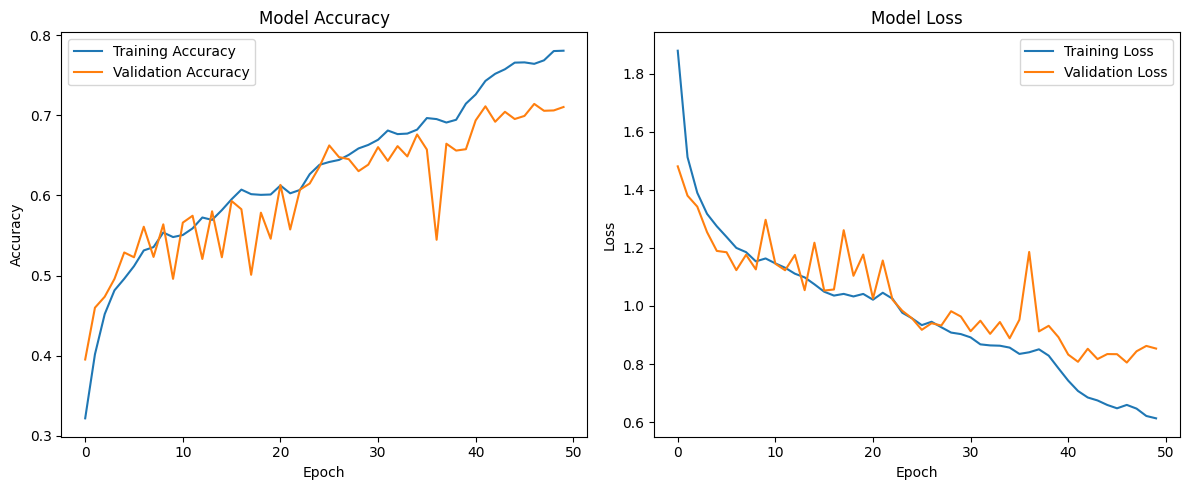

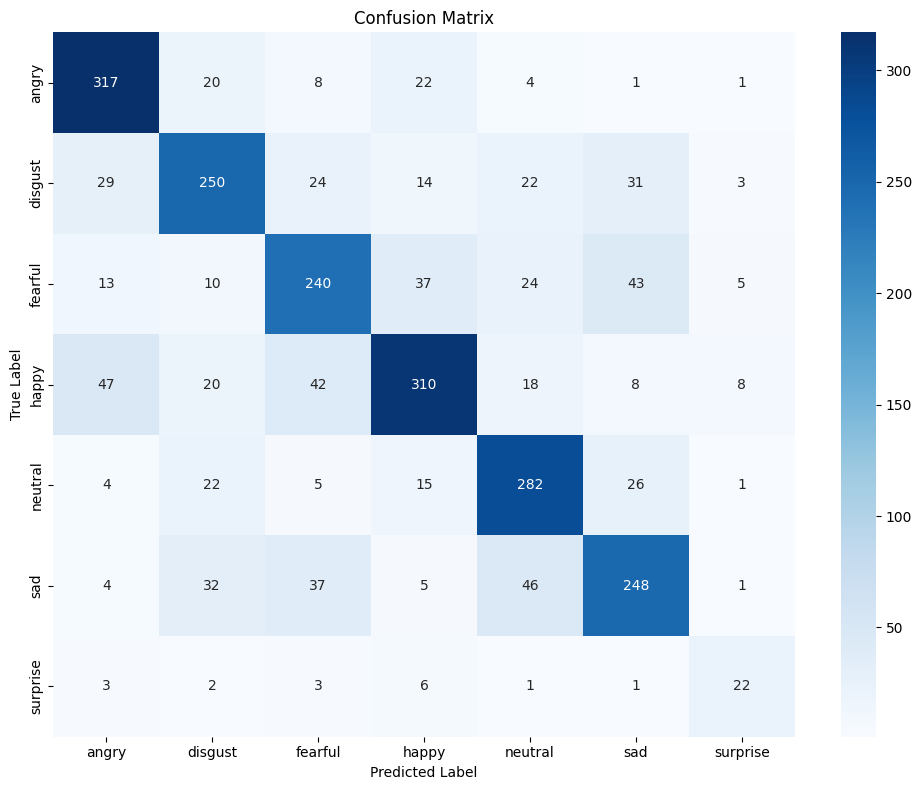

Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.85      0.80       373
     disgust       0.70      0.67      0.69       373
     fearful       0.67      0.65      0.66       372
       happy       0.76      0.68      0.72       453
     neutral       0.71      0.79      0.75       355
         sad       0.69      0.66      0.68       373
    surprise       0.54      0.58      0.56        38

    accuracy                           0.71      2337
   macro avg       0.69      0.70      0.69      2337
weighted avg       0.71      0.71      0.71      2337



In [3]:


"""## 2. Dataset Processing Functions"""

def extract_emotion_ravdess(filename):
    parts = filename.split('-')
    if len(parts) == 7:
        emotion_code = int(parts[2])
        emotion_map = {
            1: "neutral",
            2: "calm",
            3: "happy",
            4: "sad",
            5: "angry",
            6: "fearful",
            7: "disgust",
            8: "surprised"
        }
        return emotion_map.get(emotion_code, "unknown")
    return "unknown"

def extract_emotion_crema(filename):
    emotion_map = {
        "SAD": "sad",
        "ANG": "angry",
        "DIS": "disgust",
        "FEA": "fearful",
        "HAP": "happy",
        "NEU": "neutral"
    }
    for code, emotion in emotion_map.items():
        if code in filename:
            return emotion
    return "unknown"

def extract_emotion_tess(filename):
    emotion_patterns = [
        "angry", "disgust", "fear", "happy",
        "neutral", "pleasant", "sad", "surprise"
    ]
    for emotion in emotion_patterns:
        if emotion in filename.lower():
            if emotion == "fear":
                return "fearful"
            elif emotion == "pleasant":
                return "happy"  # Map pleasant to happy
            elif emotion == "surprise":
                return "surprised"
            else:
                return emotion
    return "unknown"

def extract_emotion_savee(filename):
    emotion_map = {
        'a': "angry",
        'd': "disgust",
        'f': "fearful",
        'h': "happy",
        'n': "neutral",
        'sa': "sad",
        'su': "surprised"
    }
    parts = filename.split('_')
    if parts and len(parts) > 0:
        prefix = parts[0].lower()
        if prefix in emotion_map:
            return emotion_map[prefix]
        elif len(prefix) >= 2 and prefix[:2] in emotion_map:
            return emotion_map[prefix[:2]]
    return "unknown"

def detect_dataset_type(filepath):
    filename = os.path.basename(filepath)
    if re.match(r'\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}-\d{2}', filename):
        return "RAVDESS"
    elif any(code in filename for code in ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]):
        return "CREMA"
    elif "OAF" in filepath or "YAF" in filepath:
        return "TESS"
    elif re.match(r'[a-zA-Z]{1,2}_', filename):
        return "SAVEE"
    else:
        return "UNKNOWN"

def extract_emotion(filepath):
    filename = os.path.basename(filepath)
    dataset_type = detect_dataset_type(filepath)
    if dataset_type == "RAVDESS":
        return extract_emotion_ravdess(filename)
    elif dataset_type == "CREMA":
        return extract_emotion_crema(filename)
    elif dataset_type == "TESS":
        return extract_emotion_tess(filepath)
    elif dataset_type == "SAVEE":
        return extract_emotion_savee(filename)
    else:
        return "unknown"

def extract_features(file_path, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH, sr=SAMPLE_RATE, duration=DURATION):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        if len(y) < SAMPLES:
            y = np.pad(y, (0, SAMPLES - len(y)), 'constant')
        else:
            y = y[:SAMPLES]
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T
        return mfcc
    except Exception as e:
        print(f"Error extracting features from {file_path}: {str(e)}")
        return None

def process_all_datasets(base_path):
    data = {
        'file_path': [],
        'emotion': [],
        'dataset': [],
        'features': []
    }
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                dataset_type = detect_dataset_type(file_path)
                emotion = extract_emotion(file_path)
                if emotion != "unknown":
                    features = extract_features(file_path)
                    if features is not None:
                        data['file_path'].append(file_path)
                        data['emotion'].append(emotion)
                        data['dataset'].append(dataset_type)
                        data['features'].append(features)
                        if len(data['file_path']) % 100 == 0:
                            print(f"Processed {len(data['file_path'])} files")
    emotion_mapping = {
        "calm": "neutral",
        "surprised": "surprise"
    }
    data['emotion'] = [emotion_mapping.get(e, e) for e in data['emotion']]
    return data

"""## 3. Model Training Functions"""

def build_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

def train_model(features, labels, epochs=50, batch_size=32):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    num_classes = len(np.unique(encoded_labels))
    categorical_labels = to_categorical(encoded_labels)
    X_train, X_test, y_train, y_test = train_test_split(
        features, categorical_labels, test_size=0.2, random_state=42, stratify=categorical_labels
    )
    print(f"Training data shape: {X_train.shape}")
    print(f"Testing data shape: {X_test.shape}")
    print(f"Number of emotion classes: {num_classes}")
    print(f"Emotion classes: {label_encoder.classes_}")
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape, num_classes)
    model.summary()
    checkpoint = ModelCheckpoint(
        "emotion_model_best.h5",
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True
    )
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=15,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.0001
    )
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )
    best_model = load_model("emotion_model_best.h5")
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    best_model.save("emotion_model_final.h5")
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    return best_model, label_encoder, history, y_true, y_pred

"""## 4. Visualization Functions"""

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_sample_audio(file_path, emotion):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform ({emotion})')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram ({emotion})')
    plt.tight_layout()
    plt.show()

def plot_dataset_distribution(emotions, datasets):
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(y=emotions, order=pd.Series(emotions).value_counts().index)
    plt.title('Emotion Distribution')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.subplot(1, 2, 2)
    sns.countplot(y=datasets, order=pd.Series(datasets).value_counts().index)
    plt.title('Dataset Distribution')
    plt.xlabel('Count')
    plt.ylabel('Dataset')
    plt.tight_layout()
    plt.savefig('data_distribution.png')
    plt.show()

def main():
    # Step 1: Process dataset
    print("Starting dataset processing...")
    data = process_all_datasets('/content/dataset')
    print(f"Total processed samples: {len(data['file_path'])}")
    plot_dataset_distribution(data['emotion'], data['dataset'])

    # Step 2: Prepare features
    print("Preparing features...")
    X = np.array(data['features'])
    y = np.array(data['emotion'])

    # Step 3: Train model
    print("Starting training...")
    best_model, label_encoder, history, y_true, y_pred = train_model(X, y, epochs=50, batch_size=32)

    # Step 4: Visualization
    print("Plotting training history and confusion matrix...")
    plot_training_history(history)
    plot_confusion_matrix(y_true, y_pred, label_encoder)

    # Step 5: Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

if __name__ == '__main__':
    main()